Predictive Maintenance for IoT Sensor Devices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [4]:
import shap
import warnings
warnings.filterwarnings("ignore")

C:\Users\reddy\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
train_df.shape
test_df.shape

(300, 8)

In [7]:
train_df.head()

,Timestamp,Device_ID,Temp_Sensor,Vibration_Level,Voltage_Fluctuation,Signal_Strength,Runtime_Hours,Error_Code,Vibration_Rolling3
0,2025-01-01 00:00,DVC-009,73.71,0.87,0.047,89.7,34,0,0.87
1,2025-01-01 00:10,DVC-007,71.40,0.76,0.053,87.6,51,0,0.76
2,2025-01-01 00:20,DVC-006,72.35,1.12,0.060,86.0,40,0,1.12
3,2025-01-01 00:30,DVC-001,72.26,0.51,0.054,86.1,80,0,0.51
4,2025-01-01 00:40,DVC-005,72.09,1.13,0.062,86.7,92,0,1.13


In [8]:
test_df.head()

,Timestamp,Device_ID,Temp_Sensor,Vibration_Level,Voltage_Fluctuation,Signal_Strength,Runtime_Hours,Vibration_Rolling3
0,08-01-2025 00:00,DVC-002,71.21,1.08,0.027,87.5,28,1.08
1,08-01-2025 00:10,DVC-004,73.87,0.40,0.066,87.6,99,0.40
2,08-01-2025 00:20,DVC-001,74.74,0.45,0.068,86.7,82,0.45
3,08-01-2025 00:30,DVC-004,71.51,0.70,0.040,89.3,142,0.55
4,08-01-2025 00:40,DVC-008,75.06,0.78,0.046,94.4,43,0.78


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            1000 non-null   object 
 1   Device_ID            1000 non-null   object 
 2   Temp_Sensor          1000 non-null   float64
 3   Vibration_Level      1000 non-null   float64
 4   Voltage_Fluctuation  1000 non-null   float64
 5   Signal_Strength      1000 non-null   float64
 6   Runtime_Hours        1000 non-null   int64  
 7   Error_Code           1000 non-null   int64  
 8   Vibration_Rolling3   1000 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 70.4+ KB


In [10]:
train_df.isnull().sum()

Timestamp              0
Device_ID              0
Temp_Sensor            0
Vibration_Level        0
Voltage_Fluctuation    0
Signal_Strength        0
Runtime_Hours          0
Error_Code             0
Vibration_Rolling3     0
dtype: int64

In [11]:
train_df['Failure'] = train_df['Error_Code'].apply(lambda x: 0 if x == 0 else 1)


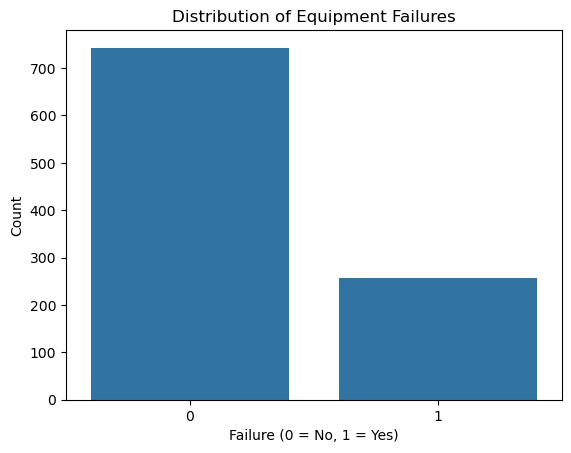

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Failure', data=train_df)
plt.title("Distribution of Equipment Failures")
plt.xlabel("Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


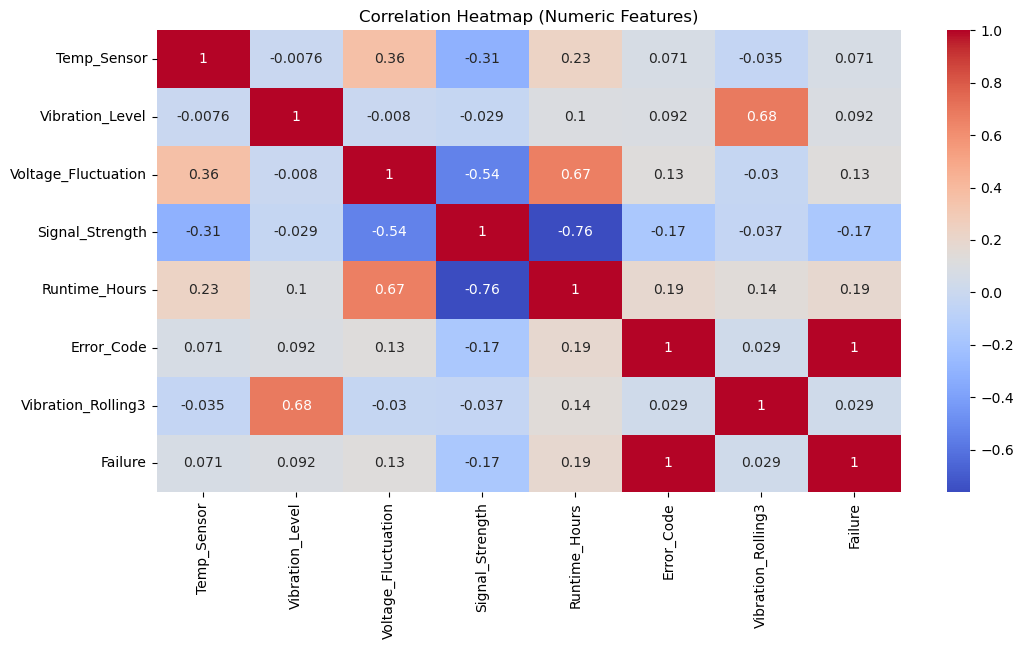

In [13]:
# Only use numeric columns for correlation
numeric_cols = train_df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


In [14]:
# Feature enginnering
def create_features(df):
    df = df.copy()
    sensor_cols = [col for col in df.columns if 'sensor' in col]

    for col in sensor_cols:
        df[f'{col}_roll_mean_3'] = df[col].rolling(window=3, min_periods=1).mean()
        df[f'{col}_diff'] = df[col].diff().fillna(0)

    return df.fillna(0)

# Apply to train and test data
train_df = create_features(train_df)
test_df = create_features(test_df)


In [15]:
X = train_df.drop(['Failure'], axis=1)
y = train_df['Failure']


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = train_df.drop(['Failure', 'Timestamp', 'Device_ID'], axis=1)
y = train_df['Failure']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


 Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00        45

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



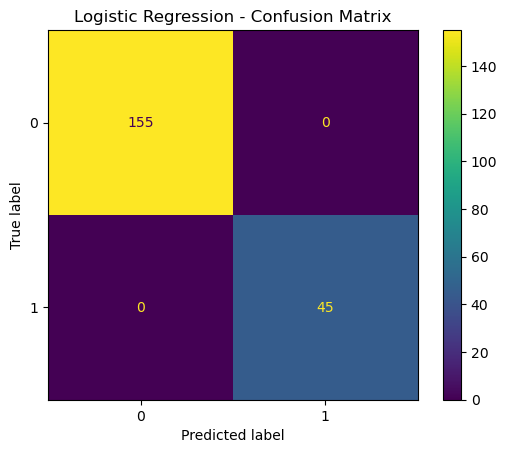

In [17]:
# model 1. Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
print(" Logistic Regression Report:")
print(classification_report(y_val, lr_preds))
ConfusionMatrixDisplay.from_predictions(y_val, lr_preds)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


 Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00        45

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



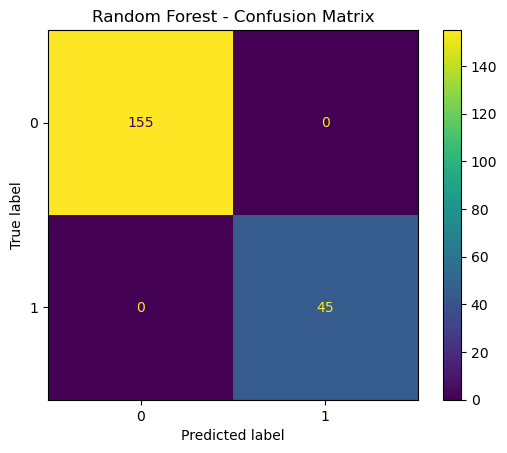

In [18]:
# Model 2 Random Forest 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print(" Random Forest Report:")
print(classification_report(y_val, rf_preds))
ConfusionMatrixDisplay.from_predictions(y_val, rf_preds)
plt.title("Random Forest - Confusion Matrix")
plt.show()


 XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00        45

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



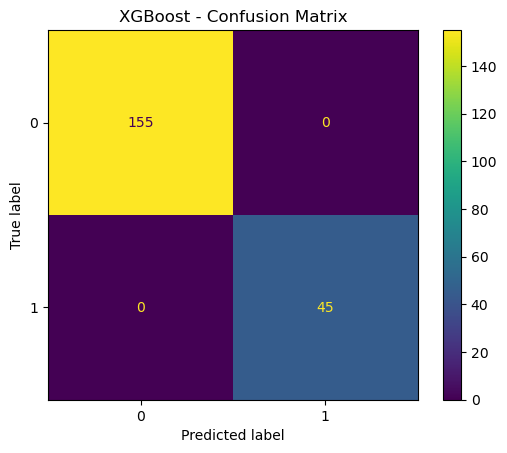

In [19]:
# model 3 XGBoost 
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
print( " XGBoost Report:")
print(classification_report(y_val, xgb_preds))
ConfusionMatrixDisplay.from_predictions(y_val, xgb_preds)
plt.title("XGBoost - Confusion Matrix")
plt.show()


In [21]:
# SHAP Summary Plot 
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)


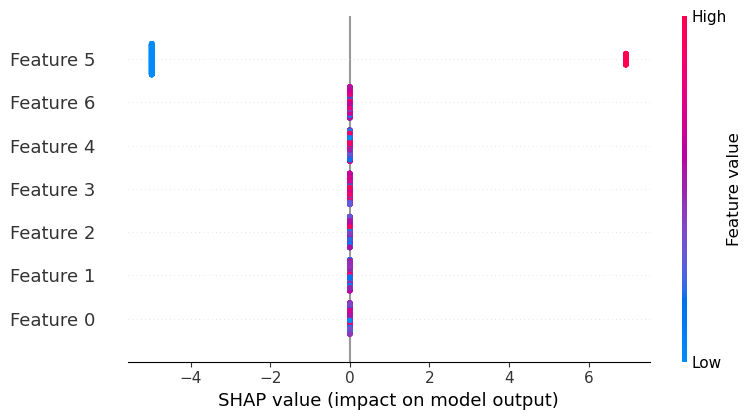

In [22]:
shap.summary_plot(shap_values, X_train, max_display=10)
